<left><img width=25% src="img/gw_monogram_2c.png"></left>

# Lecture 5: Graph Embeddings

### CS4907/CS6365 Machine Learning

__Sardar Hamidian__<br>The George Washington Universiry

__Armin Mehrabian__<br>The George Washington Universiry

# Main Question Today:

**Given a network with labels on some nodes, how do we assign labels to all other nodes in the network?**




### Example:

In a network of scientific papers, some papers are labeled as highly cited, while others are less cited. **How do you predict which other papers will become highly cited based on their connections and relationships in the network?**


We already discussed node embeddings as a method to solve this in Lecture 3.

# Main Question Today:

**Given a network with labels on some nodes, how do we assign labels to all other nodes in the network?**


### Today we will discuss an alternative framework: **message passing**


### Intuition: 

- **Correlations** exist in networks.
- Similar nodes are connected.


### Key Concept: 

**Collective classification**: Assigning labels to all nodes in a network together.


### We will look at three techniques today:

- **Relational classification**
- **Iterative classification**
- **Belief propagation**


# Correlations Exist in Networks

- Individual behaviors are **correlated** in the network.
- **Correlation**: Nearby nodes have the same color (belonging to the same class).


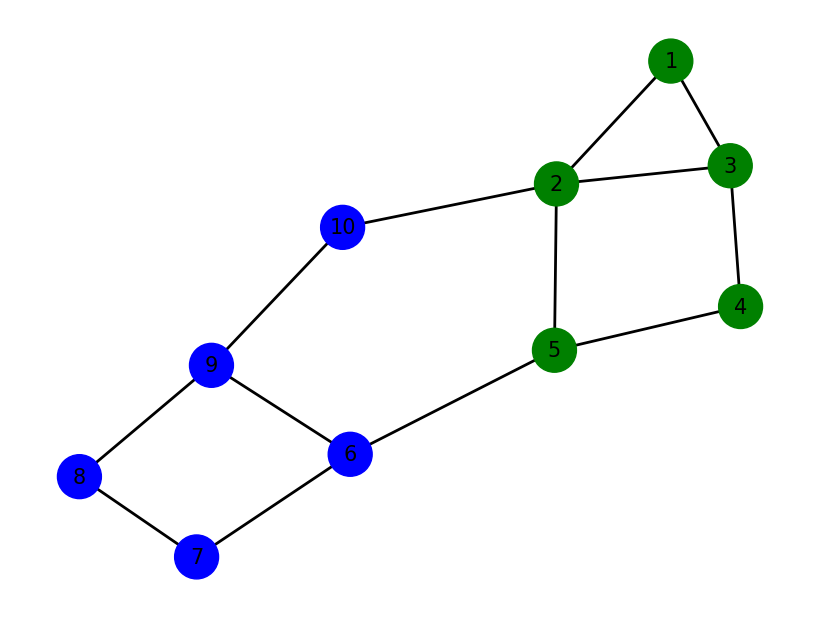

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(range(1, 11))

# Add edges to create a connected graph
edges = [(1, 2), (1, 3), (2, 3), (2, 10), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (2, 5), (6, 9)]
G.add_edges_from(edges)

# Assign node colors: nodes 1-5 one color, nodes 6-10 another color
color_map = ['green' if node in range(1, 6) else 'blue' for node in G]

# Draw the graph with node colors and layout
pos = nx.spring_layout(G)  # Use spring layout for better node spacing
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1000, font_size=15, edge_color='black', width=2)
plt.show()


## 1. Homophily

**Homophily**: The tendency of individuals to associate and bond with similar others  
- *"Birds of a feather flock together"*
- It has been observed in a vast array of network studies, based on a variety of attributes (e.g., age, gender, organizational role, etc.)

**Example**:  
- Researchers who focus on the same research area are more likely to establish a connection (meeting at conferences, interacting in academic talks, etc.)


## Example of Homophily

- **Online social network**  
  - Nodes = people  
  - Edges = friendship  
  - Node color = interests (sports, arts, etc.)
  
- **Key Insight:**  
  - People with the same interest are more closely connected due to homophily

- **Source:**
  - David Easley and Jon Kleinberg. Networks, Crowds, and Markets: Reasoning About a Highly Connected World. 2010.

![Homophily Example](img/homophily_example.png)


## 2. Influence

- **Influence**: Social or professional connections can influence the individual characteristics or work of a researcher.
  
- **Example**: In a citation network, a researcher may be influenced by frequently citing the work of a prominent researcher. Over time, their work starts to align more with the ideas and concepts from the cited research, shaping their own contributions in the field.


# **Classification with Network Data**

- How do we leverage this correlation observed in networks to help predict node labels?

- How do we predict the labels for the nodes in grey?


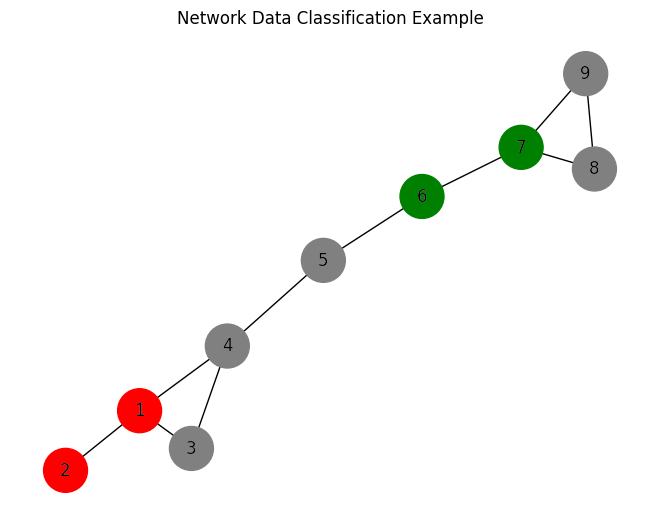

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add edges between nodes (based on the image structure)
edges = [(9, 8), (9, 7), (8, 7), (7, 6), (6, 5), (5, 4), (4, 3), (3, 1), (1, 2), (4, 1)]
G.add_edges_from(edges)


# Node colors
color_map = ['green' if node in [6, 7] else 'red' if node in [1, 2] else 'gray' for node in G.nodes()]

# Draw the network graph
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1000, font_color='white', font_size=12)
nx.draw_networkx_labels(G, pos)

# Show the plot
plt.title("Network Data Classification Example")
plt.show()


# Motivation

- **Similar nodes are typically close together or directly connected in the network:**

  - **Guilt-by-association:**  
    _If I am connected to a node with label X, then I am likely to have label X as well._
  
  - **Example: Malicious/benign web page:**  
    _Malicious web pages link to one another to increase visibility, look credible, and rank higher in search engines._


# Motivation 

- **Classification label of a node $v$ in network may depend on:**

  - Features of **$v$** 
  
  - Labels of the nodes in **$v$** neighborhood 
  
  - Features of the nodes in **$v$** neighborhood

# Semi-supervised Learning (1)

**Given:**
- Graph
- Few labeled nodes

**Find:** class (**red/green**) of remaining nodes

**Main assumption:**  
There is homophily in the network


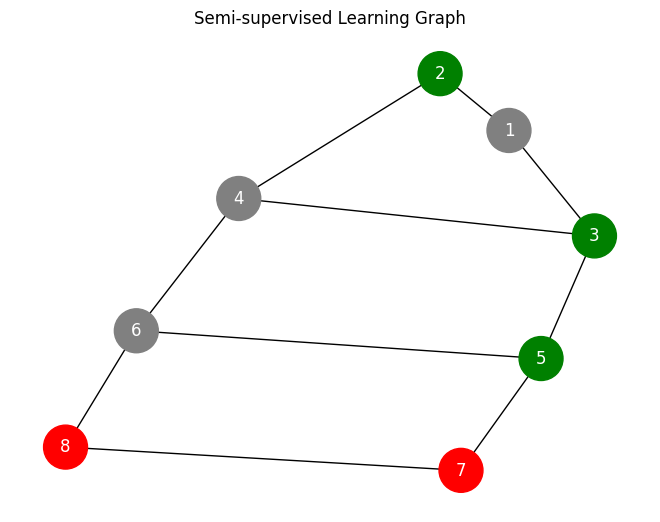

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add edges between nodes (based on the structure from the image)
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 6), (5, 6), (5, 7), (6, 8), (7, 8)]
G.add_edges_from(edges)

# Define node labels (colors) based on the description (green = 1, red = 0, gray = unknown)
node_labels = {2: 'green', 3: 'green', 5: 'green', 7: 'red', 8: 'red'}

# Define node colors (green, red, gray)
node_colors = ['green' if node in [2, 3, 5] else 'red' if node in [7, 8] else 'gray' for node in G.nodes()]

# Draw the network graph
pos = nx.spring_layout(G, seed=42)  # for consistent layout
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_color='white', font_size=12)

# Display the plot
plt.title("Semi-supervised Learning Graph")
plt.show()


# **Semi-supervised Learning (2)**

**Example task:**

- Let $A$ be a $n \times n$ adjacency matrix over $n$ nodes.
- Let $Y = \{0,1\}^n$ be a vector of **labels**:
  - $Y_v = 1$ belongs to **Class 1** (green)
  - $Y_v = 0$ belongs to **Class 0** (red)
  - There are **unlabeled** nodes that need to be classified.

**Goal:**  
Predict which **unlabeled** nodes are likely **Class 1**, and which are likely **Class 0**.


# **Adjacency Matrix and Label Vector**

- **Adjacency Matrix \( A \):**
  The adjacency matrix represents the connections between the nodes in the graph.

$$
A = \begin{bmatrix}
0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 1 & 1 & 0 & 0 & 0 \\
0 & 1 & 1 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 & 1 & 1 & 0 \\
\end{bmatrix}
$$

- **Label Vector \( Y \):**
  The label vector assigns class labels to each node. Nodes labeled as **-1** are **unlabeled**.

$$
Y = \begin{bmatrix}
-1 \\
1 \\
1 \\
-1 \\
1 \\
-1 \\
0 \\
0 \\
\end{bmatrix}
$$


# Collective Classification Overview 

- **Intuition:** Simultaneous classification of interlinked nodes using correlations.
- **Probabilistic framework**

- **Markov Assumption:**
  The label $(Y_v)$ of one node $(v)$ depends on the labels of its neighbors $(N_v)$:

$$
P(Y_v | N_v)
$$


# Collective Classification Overview 

**Collective classification involves 3 steps:**

1. **Local Classifier:**
   - Assign initial labels

2. **Relational Classifier:**
   - Capture correlations between nodes

3. **Collective Inference:**
   - Propagate correlations through the network



# 1. Local Classifier

- Used for initial label assignment:
  - Predicts label based on node attributes/features.
  - Standard classification task.
  - Does not use network information.



# 2. Relational Classifier

- Looks at connections between nodes:
  - Learns how to label a node based on the labels or features of its neighboring nodes.
  - This step uses the network information (the connections between nodes).



# 3. Collective Inference

- Spreads label information through the network:
  - Uses the relational classifier to label each node one by one.
  - Repeats until most neighboring nodes have similar labels.
  - The network structure affects the final labels.


# Problem Setting

- How to predict the labels $Y_v$ for the **unlabeled** nodes $v$ (in grey color)?
- Each node $v$ has a feature vector $f_v$.
- Labels for some nodes are given (**1 for green**, **0 for red**).

### Task:
- Find $P(Y_v)$ given all features and the network.

$$ P(Y_v) = ? $$


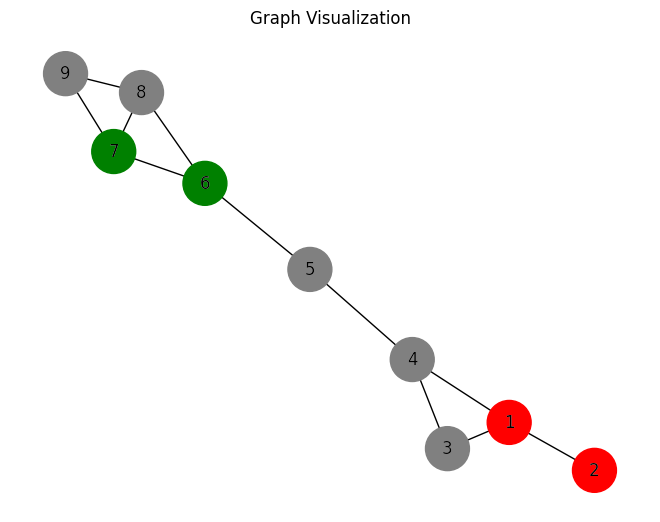

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add edges based on the structure from the image
edges = [(9, 7), (9, 8), (7, 8), (7, 6), (8, 6), (6, 5), (5, 4), (4, 1), (4, 3), (1, 2), (1, 3)]
G.add_edges_from(edges)


# Define node colors (green for 1, red for 0, gray for unlabeled)
node_colors = ['green' if node in [6, 7] else 'red' if node in [1, 2] else 'gray' for node in G.nodes()]

# Draw the network graph
pos = nx.spring_layout(G, seed=42)  # Consistent layout
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1000, font_color='white', font_size=12)
nx.draw_networkx_labels(G, pos)

# Show the plot
plt.title("Graph Visualization")
plt.show()


<left><img width=25% src="img/gw_monogram_2c.png"></left>

# Part 2: Relational Classifier



# Probabilistic Relational Classifier

- **Basic idea:** Class probability $Y_v$ of node $v$ is a weighted average of class probabilities of its neighbors.
  
- For **labeled nodes** $v$, initialize label $Y_v$ with ground-truth label $Y_v^*$.

- For **unlabeled nodes**, initialize with a uniform distribution, i.e. two classes: $Y_v = 0.5$.

- **Update** all nodes in a random order until convergence or until the maximum number of iterations is reached.

**Note**: Here we are only using labels and graph structure (No node or edge attributes)


# Probabilistic Relational Classifier

### Update for each node $v$ and label $c$ (e.g., 0 or 1):

$$
P(Y_v = c) = \frac{1}{\sum_{(v,u) \in E} A_{v,u}} \sum_{(v,u) \in E} A_{v,u} P(Y_u = c)
$$

### Explanation:
- **$P(Y_v = c)$**: This is the probability that node $v$ has label $c$ (e.g., 0 or 1).
- **$A_{v,u}$**: Represents the edge strength or weight between nodes $v$ and $u$. If there is no weight, it is usually 1.
- **$\sum_{(v,u) \in E}$**: This sums over all neighbors $u$ of node $v$.
- The formula updates the probability of node $v$ having label $c$ by taking a weighted average of its neighbors' probabilities of having label $c$.



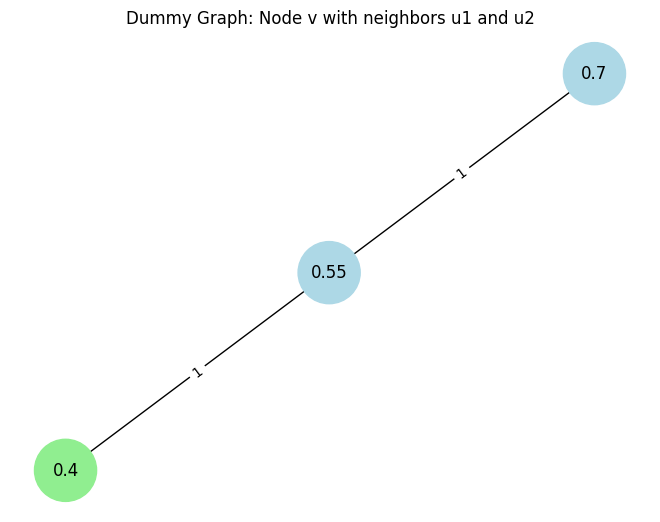

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph object
G = nx.Graph()

# Add edges for the dummy graph: v connected to u1 and u2
G.add_edges_from([('v', 'u1'), ('v', 'u2')])

# Define the node labels based on the probability example
node_labels = {'u1': '0.7', 'u2': '0.4', 'v': '0.55'}

# Define node colors (for visualization purposes)
node_colors = ['lightblue', 'lightblue', 'lightgreen']  # u1, u2 (lightblue), v (lightgreen)

# Draw the network graph
pos = nx.spring_layout(G, seed=42)  # Consistent layout
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color=node_colors, node_size=2000, font_size=12)

# Draw edge labels (weights)
edge_labels = {('v', 'u1'): '1', ('v', 'u2'): '1'}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Dummy Graph: Node v with neighbors u1 and u2")
plt.show()


### Dummy Example:
- Suppose node $v$ has two neighbors, $u_1$ and $u_2$, with the following probabilities for label 1:
  - $P(Y_{u_1} = 1) = 0.7$
  - $P(Y_{u_2} = 1) = 0.4$
  
- Assume the edge weights between $v$ and its neighbors are 1 (i.e., $A_{v,u_1} = 1$ and $A_{v,u_2} = 1$).

- Using the formula to compute $P(Y_v = 1)$:
  
$$
P(Y_v = 1) = \frac{1}{1 + 1} \left( 1 \times 0.7 + 1 \times 0.4 \right)
$$

$$
P(Y_v = 1) = \frac{1}{2} \times (0.7 + 0.4) = \frac{1}{2} \times 1.1 = 0.55
$$

- So, the updated probability that node $v$ has label 1 is 0.55.




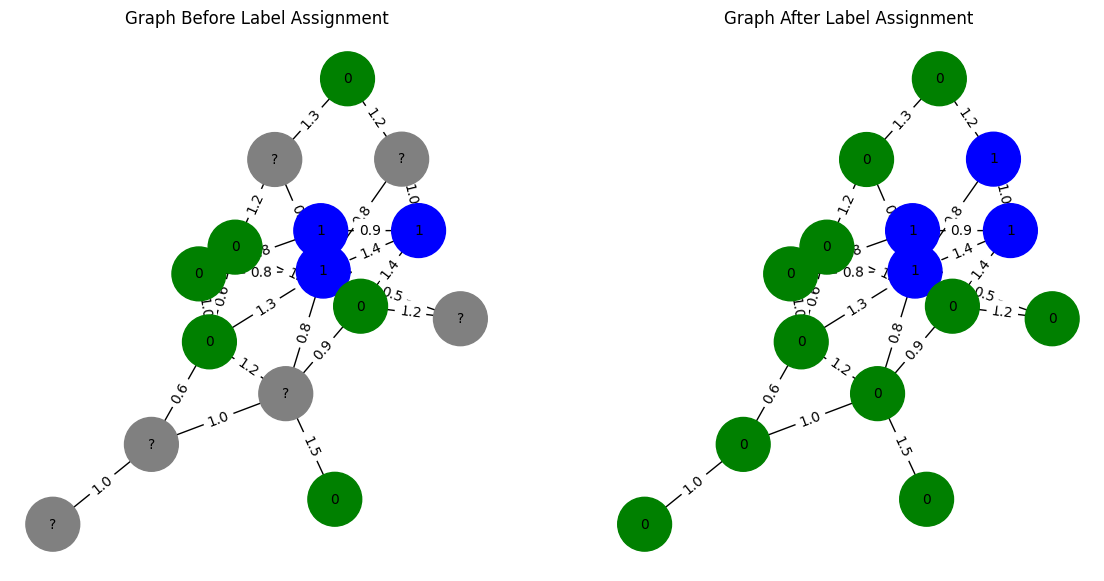

In [24]:
import torch
import torch_geometric
import matplotlib.pyplot as plt
import networkx as nx
import random
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from sklearn.preprocessing import normalize

# Step 1: Generate a random graph with 15 nodes and 30 edges
num_nodes = 15
num_edges = 30
edge_index = torch.tensor([random.sample(range(num_nodes), 2) for _ in range(num_edges)], dtype=torch.long).T

# Assign random edge weights between 0.5 and 1.5
edge_weights = torch.tensor([random.uniform(0.5, 1.5) for _ in range(num_edges)], dtype=torch.float)

# Step 2: Randomly assign labels to 50% of the nodes (either 0 or 1), leaving others unlabeled (-1)
x_initial = torch.tensor([random.choice([0, 1]) if random.random() < 0.5 else -1 for _ in range(num_nodes)], dtype=torch.float).unsqueeze(1)

# Step 3: Create a Data object
data = Data(x=x_initial, edge_index=edge_index, edge_weight=edge_weights)

# Convert the data to a NetworkX graph for visualization
G_initial = to_networkx(data, to_undirected=True)

# Step 4: Implement the label propagation process (ensuring ground truth labels remain fixed)
def label_propagation(data, max_iter=10):
    # Extract the adjacency matrix
    num_nodes = data.num_nodes
    adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float)

    # Populate the adjacency matrix using edge_index and edge_weight
    for i, (src, dst) in enumerate(data.edge_index.T):
        weight = data.edge_weight[i]
        adjacency_matrix[src, dst] = weight
        adjacency_matrix[dst, src] = weight  # Since it's undirected

    # Normalize the adjacency matrix (row-normalized for label propagation)
    norm_adj_matrix = normalize(adjacency_matrix.numpy(), norm='l1', axis=1)  # Use numpy for normalization
    norm_adj_matrix = torch.tensor(norm_adj_matrix, dtype=torch.float)  # Convert back to tensor with float32

    # Initialize the labels
    labels = data.x.clone()  # Copy the node features (labels)
    
    # Propagate labels over the graph for max_iter iterations
    for _ in range(max_iter):
        new_labels = torch.matmul(norm_adj_matrix, labels)
        
        # FIX: Do not change ground truth labels (ground truth labels should remain fixed)
        for i in range(num_nodes):
            if data.x[i].item() != -1:  # If the node has a ground truth label, skip it
                new_labels[i] = data.x[i]

        # Assign the new labels for unlabeled nodes
        labels = new_labels

    # Ensure that all labels are either 0 or 1 (rounding)
    labels = torch.round(labels).clamp(0, 1)
    
    return labels

# Run label propagation on the graph
final_labels = label_propagation(data)

# Set final predictions for the nodes (after label propagation) to either 0 or 1
x_final = final_labels.int()  # Ensure the final labels are integers (0 or 1)

# Create the data object for the final state
data_final = Data(x=x_final, edge_index=edge_index)

# Convert the data to a NetworkX graph for visualization
G_final = to_networkx(data_final, to_undirected=True)

# Step 5: Define labels and visualize

# Define the initial labels (before label assignment)
node_labels_initial = {i: str(int(x_initial[i].item())) if x_initial[i].item() != -1 else '?' for i in range(num_nodes)}

# Define the final labels (after label assignment)
node_labels_final = {i: str(x_final[i].item()) for i in range(num_nodes)}

# Create figure for side-by-side visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Visualization of the graph without labels (before label assignment)
pos = nx.spring_layout(G_initial, seed=42)  # Fixed layout for consistent visualization
# Initial colors: Class 0 (green), Class 1 (blue), Unlabeled (gray)
node_colors_initial = ['green' if x_initial[i].item() == 0 else 'blue' if x_initial[i].item() == 1 else 'gray' for i in range(num_nodes)]
nx.draw(G_initial, pos, with_labels=True, labels=node_labels_initial, node_color=node_colors_initial, 
        node_size=1500, font_size=10, ax=ax1)

# Add edge weights from the edge_weights tensor for the initial graph
edge_labels_initial = {(edge_index[0, i].item(), edge_index[1, i].item()): f'{edge_weights[i].item():.1f}' for i in range(edge_index.size(1))}
nx.draw_networkx_edge_labels(G_initial, pos, edge_labels=edge_labels_initial, ax=ax1)
ax1.set_title("Graph Before Label Assignment")

# Visualization of the graph with labels (after label assignment)
# Final colors: Class 0 (green), Class 1 (blue)
node_colors_final = ['green' if final_labels[i].item() == 0 else 'blue' for i in range(num_nodes)]
nx.draw(G_final, pos, with_labels=True, labels=node_labels_final, node_color=node_colors_final, 
        node_size=1500, font_size=10, ax=ax2)

# Add edge weights from the edge_weights tensor for the final graph
edge_labels_final = {(edge_index[0, i].item(), edge_index[1, i].item()): f'{edge_weights[i].item():.1f}' for i in range(edge_index.size(1))}
nx.draw_networkx_edge_labels(G_final, pos, edge_labels=edge_labels_final, ax=ax2)
ax2.set_title("Graph After Label Assignment")

# Show the plot
plt.show()


# Label Propagation Update Methods

### Synchronous Update:
- **All nodes are updated at once** in each iteration.
- Nodes use the labels from the **previous iteration** to compute their new label probabilities.
- Once all nodes' new labels are calculated, they are updated simultaneously for the next iteration.

#### Advantages:
- Stable updates (no bias from update order).
- Easier to implement and parallelize.

#### Disadvantages:
- Can converge slower (requires more iterations).


# Label Propagation Update Methods

### Asynchronous Update:
- **Nodes are updated sequentially** in each iteration.
- Once a node's new label is calculated, it is **immediately updated** and used for the next node’s calculation.

#### Advantages:
- Often converges faster.
- Uses the most recent information, leading to quicker label propagation.

#### Disadvantages:
- Result can depend on the order of node updates.
- More difficult to parallelize.




### Challenges:
- **Convergence**: The process might not always converge to a stable state.
- **Feature Limitation**: The model does not take node features (e.g., attributes) into account, only connections.


<left><img width=25% src="img/gw_monogram_2c.png"></left>

# Part 2: Iterative Classifiers



# Previously on Iterative Classification

- **Relational classifiers** do not use node **attributes**. How can one leverage them?

- **Main idea of iterative classification**: 
  - Classify node $v$ based on its **attributes** $f_v$ as well as the **labels** $z_v$ of its neighbor set $N_v$.


# Iterative Classification

### Input: Graph
- $f_v$: feature vector for node $v$
- Some nodes $v$ are labeled with $Y_v$

### Task:
- Predict the label of unlabeled nodes.

### Approach: Train two classifiers:
- $\phi_1(f_v)$ = Predict node label based on node feature vector $f_v$
- $\phi_2(f_v, z_v)$ = Predict label based on node feature vector $f_v$ and summary $z_v$ of labels of $v$'s neighbors.


# Computing the Summary $z_v$

### How do we compute the summary $z_v$ of labels of $v$'s neighbors $N_v$?

### Ideas: $z_v$ = vector
- Histogram of the number (or fraction) of each label in $N_v$.
- Most common label in $N_v$.
- Number of different labels in $N_v$.


### Phase 1: Classify based on node attributes alone
- On a **training set**, train classifier (e.g., linear classifier, neural networks, ...):
  - $\phi_1(f_v)$ to predict $Y_v$ based on $f_v$
  - $\phi_2(f_v, z_v)$ to predict $Y_v$ based on $f_v$ and summary $z_v$ of labels of $v$'s neighbors


### Phase 2: Iterate till convergence
- On **test set**, set labels $Y_v$ based on the classifier $\phi_1$, compute $z_v$ and **predict the labels with** $\phi_2$
- **Repeat** for each node $v$:
  - Update $z_v$ based on $Y_u$ for all $u \in N_v$
  - Update $Y_v$ based on the new $z_v$ ($\phi_2$)
  
- Iterate until class labels stabilize or max number of iterations is reached.

**Note**: Convergence is not guaranteed.


# Example: Web Page Classification

- **Input:** Graph of web pages
- **Node:** Web page
- **Edge:** Hyper-link between web pages
  - **Directed edge:** a page points to another page
- **Node features:** Webpage description
  - For simplicity, we only consider 2 features
- **Task:** Predict the topic of the webpage


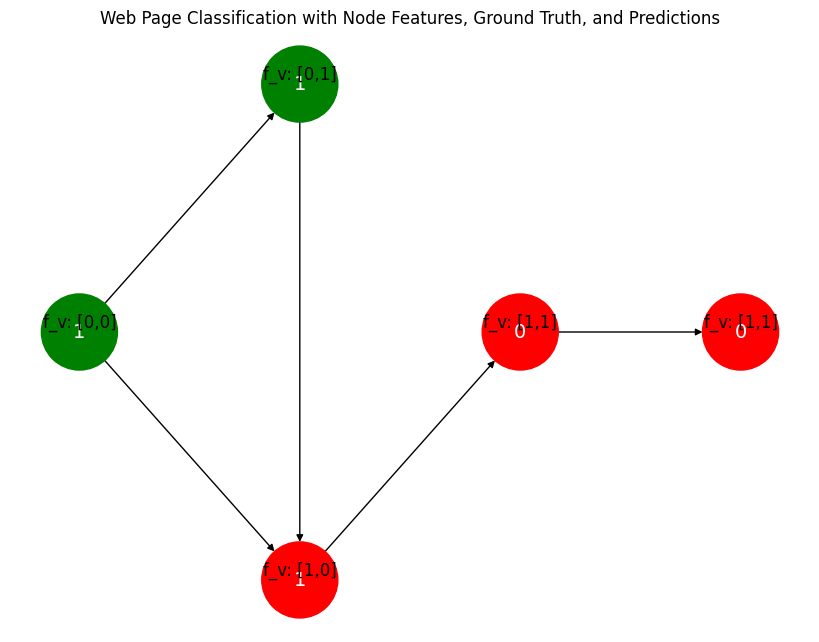

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the graph structure
G = nx.DiGraph()

# Add nodes with positions and node features (attributes)
pos = {0: (0, 1), 1: (1, 2), 2: (1, 0), 3: (2, 1), 4: (3, 1)}  # Fixed positions
node_features = {0: '[0,0]', 1: '[0,1]', 2: '[1,0]', 3: '[1,1]', 4: '[1,1]'}

# Ground truth and predictions
ground_truth = {0: 1, 1: 1, 2: 0, 3: 0, 4: 0}  # Ground truth
predictions = {0: 1, 1: 1, 2: 1, 3: 0, 4: 0}  # Predicted labels for nodes

# Add edges (directed edges between web pages)
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4)])

# Node colors based on the ground truth (green for 1, red for 0)
node_colors = ['green' if ground_truth[node] == 1 else 'red' for node in ground_truth]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=3000, font_size=12, font_color='white', arrows=True)

# Draw predicted labels inside the nodes
prediction_labels = {0: str(predictions[0]), 1: str(predictions[1]), 2: str(predictions[2]), 3: str(predictions[3]), 4: str(predictions[4])}
nx.draw_networkx_labels(G, pos, labels=prediction_labels, font_color='white', font_size=14)

# Draw node labels with node features below the nodes
labels = {0: 'f_v: [0,0]', 1: 'f_v: [0,1]', 2: 'f_v: [1,0]', 3: 'f_v: [1,1]', 4: 'f_v: [1,1]'}
nx.draw_networkx_labels(G, pos, labels=labels, font_color='black', font_size=12, verticalalignment='bottom')

# Show the plot
plt.title("Web Page Classification with Node Features, Ground Truth, and Predictions")
plt.show()


# Example: Web Page Classification

- Each node maintains **vectors** $z_v$ of neighborhood labels:
  - $I$ = Incoming neighbor label information vector
  - $O$ = Outgoing neighbor label information vector

- $I_0 = 1$ if at least one of the incoming pages is labeled 0.
  - Similar definitions for $I_1$, $O_0$, and $O_1$.

### Include network features:
- Nodes incorporate both node features $f_v$ and neighborhood label information vectors $z_v$.


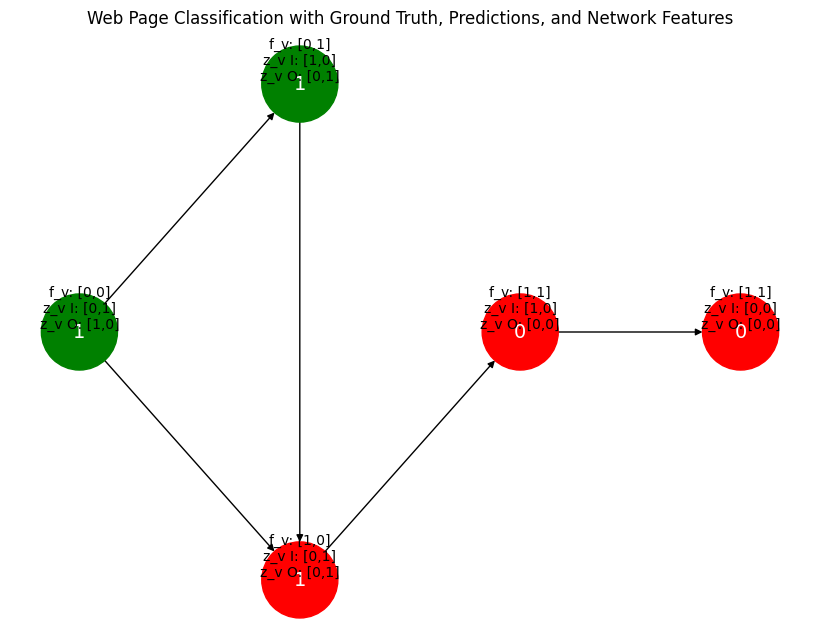

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the graph structure
G = nx.DiGraph()

# Add nodes with positions and node features (attributes)
pos = {0: (0, 1), 1: (1, 2), 2: (1, 0), 3: (2, 1), 4: (3, 1)}  # Fixed positions

# Define the incoming and outgoing neighborhood information (I, O) vectors
incoming_outgoing = {
    0: {'I': '[0,1]', 'O': '[1,0]'},
    1: {'I': '[1,0]', 'O': '[0,1]'},
    2: {'I': '[0,1]', 'O': '[0,1]'},
    3: {'I': '[1,0]', 'O': '[0,0]'},
    4: {'I': '[0,0]', 'O': '[0,0]'}
}

# Ground truth and predictions
ground_truth = {0: 1, 1: 1, 2: 0, 3: 0, 4: 0}  # Ground truth
predictions = {0: 1, 1: 1, 2: 1, 3: 0, 4: 0}  # Predicted labels for nodes

# Add edges (directed edges between web pages)
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4)])

# Node colors based on the ground truth (green for 1, red for 0)
node_colors = ['green' if ground_truth[node] == 1 else 'red' for node in ground_truth]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=3000, arrows=True)

# Draw node labels including prediction and vectors (I, O)
labels = {0: f"f_v: [0,0]\nz_v I: {incoming_outgoing[0]['I']}\nz_v O: {incoming_outgoing[0]['O']}",
          1: f"f_v: [0,1]\nz_v I: {incoming_outgoing[1]['I']}\nz_v O: {incoming_outgoing[1]['O']}",
          2: f"f_v: [1,0]\nz_v I: {incoming_outgoing[2]['I']}\nz_v O: {incoming_outgoing[2]['O']}",
          3: f"f_v: [1,1]\nz_v I: {incoming_outgoing[3]['I']}\nz_v O: {incoming_outgoing[3]['O']}",
          4: f"f_v: [1,1]\nz_v I: {incoming_outgoing[4]['I']}\nz_v O: {incoming_outgoing[4]['O']}"}

# Draw predictions as labels (in white text, showing the predicted label inside the node)
prediction_labels = {0: str(predictions[0]), 1: str(predictions[1]), 2: str(predictions[2]), 3: str(predictions[3]), 4: str(predictions[4])}
nx.draw_networkx_labels(G, pos, labels=prediction_labels, font_color='white', font_size=14)

# Draw additional labels for node features and I/O vectors (in black, outside the node)
nx.draw_networkx_labels(G, pos, labels=labels, font_color='black', font_size=10, verticalalignment='bottom')

# Show the plot
plt.title("Web Page Classification with Ground Truth, Predictions, and Network Features")
plt.show()


# Iterative Classifier – Step 3.1

### Update $z_v$ for all nodes

1. Train classifier
2. Apply classifier to test
3. Iterate
   1. Update relational features $z_v$
   2. Update label $Y_v$


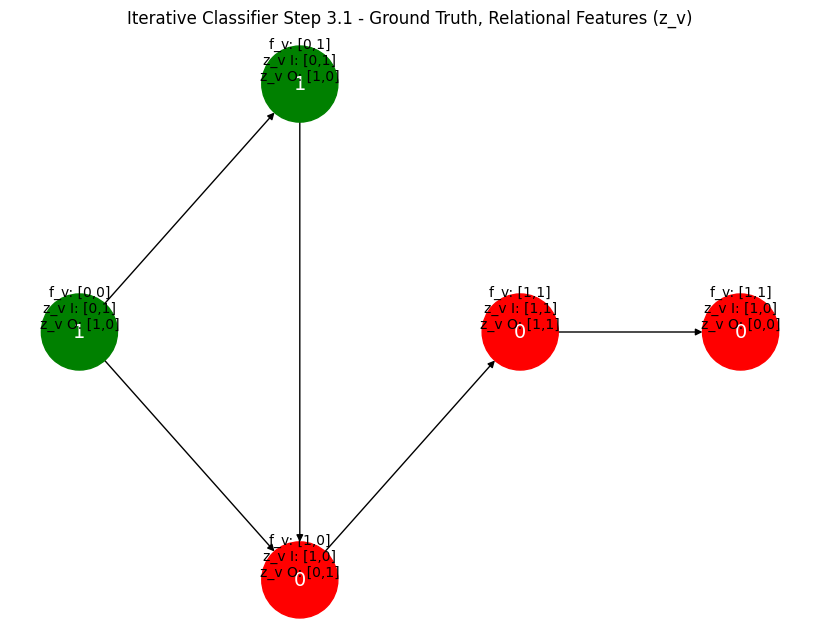

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the graph structure
G = nx.DiGraph()

# Add nodes with positions and node features (attributes)
pos = {0: (0, 1), 1: (1, 2), 2: (1, 0), 3: (2, 1), 4: (3, 1)}  # Fixed positions

# Define the relational features (z_v) for incoming (I) and outgoing (O) vectors
relational_features = {
    0: {'I': '[0,1]', 'O': '[1,0]'},
    1: {'I': '[0,1]', 'O': '[1,0]'},
    2: {'I': '[1,0]', 'O': '[0,1]'},
    3: {'I': '[1,1]', 'O': '[1,1]'},
    4: {'I': '[1,0]', 'O': '[0,0]'}
}

# Ground truth labels for nodes
ground_truth = {0: 1, 1: 1, 2: 0, 3: 0, 4: 0}  # Ground truth

# Add edges (directed edges between nodes)
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4)])

# Node colors based on the ground truth
node_colors = ['green' if ground_truth[node] == 1 else 'red' for node in ground_truth]

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=3000, arrows=True)

# Add labels for relational features (z_v: I and O vectors)
labels = {
    0: f"f_v: [0,0]\nz_v I: {relational_features[0]['I']}\nz_v O: {relational_features[0]['O']}",
    1: f"f_v: [0,1]\nz_v I: {relational_features[1]['I']}\nz_v O: {relational_features[1]['O']}",
    2: f"f_v: [1,0]\nz_v I: {relational_features[2]['I']}\nz_v O: {relational_features[2]['O']}",
    3: f"f_v: [1,1]\nz_v I: {relational_features[3]['I']}\nz_v O: {relational_features[3]['O']}",
    4: f"f_v: [1,1]\nz_v I: {relational_features[4]['I']}\nz_v O: {relational_features[4]['O']}"
}

# Draw predicted labels inside the nodes (for clarity)
ground_truth_labels = {0: '1', 1: '1', 2: '0', 3: '0', 4: '0'}
nx.draw_networkx_labels(G, pos, labels=ground_truth_labels, font_color='white', font_size=14)

# Draw additional labels for node features and z_v vectors
nx.draw_networkx_labels(G, pos, labels=labels, font_color='black', font_size=10, verticalalignment='bottom')

# Show the plot
plt.title("Iterative Classifier Step 3.1 - Ground Truth, Relational Features (z_v)")
plt.show()


# Summary

- **We talked about 2 approaches to collective classification**:
  
### Relational classification
- Iteratively update probabilities of node belonging to a label class based on its neighbors.

### Iterative classification
- Improve over collective classification to handle attribute/feature information.
- Classify node $i$ based on its **features** as well as **labels** of neighbors.


Initial Predictions (Node Features Only): [1 1 0 1 1]
Accuracy (Initial): 0.8


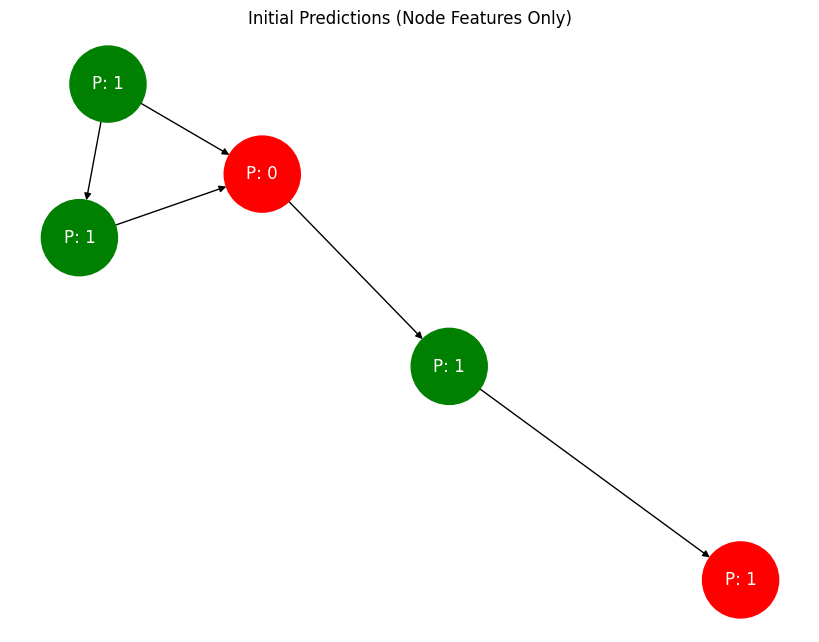


Iteration 1
Node 0, f_v: [0, 0], z_v: [0.5]
Node 1, f_v: [0, 1], z_v: [0.]
Node 2, f_v: [1, 0], z_v: [1.]
Node 3, f_v: [1, 1], z_v: [1.]
Node 4, f_v: [1, 1], z_v: [0.]
Updated Predictions: [1 1 0 1 0]
Accuracy (Iteration 1): 1.0

Iteration 2
Node 0, f_v: [0, 0], z_v: [0.5]
Node 1, f_v: [0, 1], z_v: [0.]
Node 2, f_v: [1, 0], z_v: [1.]
Node 3, f_v: [1, 1], z_v: [0.]
Node 4, f_v: [1, 1], z_v: [0.]
Updated Predictions: [1 1 0 1 1]
Accuracy (Iteration 2): 0.8

Iteration 3
Node 0, f_v: [0, 0], z_v: [0.5]
Node 1, f_v: [0, 1], z_v: [0.]
Node 2, f_v: [1, 0], z_v: [1.]
Node 3, f_v: [1, 1], z_v: [1.]
Node 4, f_v: [1, 1], z_v: [0.]
Updated Predictions: [1 1 0 1 0]
Accuracy (Iteration 3): 1.0

Iteration 4
Node 0, f_v: [0, 0], z_v: [0.5]
Node 1, f_v: [0, 1], z_v: [0.]
Node 2, f_v: [1, 0], z_v: [1.]
Node 3, f_v: [1, 1], z_v: [0.]
Node 4, f_v: [1, 1], z_v: [0.]
Updated Predictions: [1 1 0 1 1]
Accuracy (Iteration 4): 0.8

Iteration 5
Node 0, f_v: [0, 0], z_v: [0.5]
Node 1, f_v: [0, 1], z_v: [0.]
Node

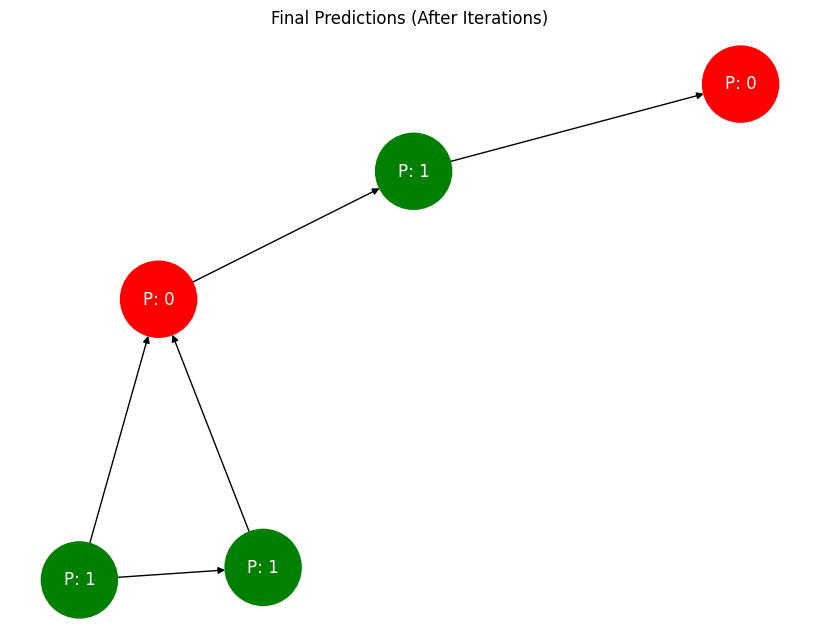

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Step 1: Create the graph structure
G = nx.DiGraph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (2, 3), (3, 4)])  # Add directed edges

# Node features (f_v) - for simplicity, binary features
node_features = {
    0: [0, 0],
    1: [0, 1],
    2: [1, 0],
    3: [1, 1],
    4: [1, 1],
}

# Ground truth labels for nodes
ground_truth = {0: 1, 1: 1, 2: 0, 3: 1, 4: 0}

# Create feature matrix X and label vector y
X = np.array([node_features[i] for i in range(len(node_features))])
y = np.array([ground_truth[i] for i in range(len(ground_truth))])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Train the first classifier (only using node features)
clf = LogisticRegression()
clf.fit(X_scaled, y)

# Make initial predictions based only on node features
initial_predictions = clf.predict(X_scaled)
print(f"Initial Predictions (Node Features Only): {initial_predictions}")
print(f"Accuracy (Initial): {accuracy_score(y, initial_predictions)}")

# Plot initial prediction graph
def plot_graph(G, predictions, title):
    pos = nx.spring_layout(G)
    node_colors = ['green' if ground_truth[node] == 1 else 'red' for node in G.nodes]
    prediction_labels = {i: f'P: {pred}' for i, pred in enumerate(predictions)}
    
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, with_labels=False, node_size=3000, font_color='white')
    nx.draw_networkx_labels(G, pos, labels=prediction_labels, font_color='white')
    plt.title(title)
    plt.show()

# Plot initial graph
plot_graph(G, initial_predictions, "Initial Predictions (Node Features Only)")

# Step 3: Iteratively update the node features by incorporating neighbor labels
def update_relational_features(G, predictions):
    new_features = []
    for node in G.nodes:
        neighbors = list(G.neighbors(node))  # Get neighbors of the node
        if neighbors:
            neighbor_labels = predictions[neighbors]
            # Create a new feature combining the original node features with the mean of neighbor labels
            new_feature = list(node_features[node]) + [np.mean(neighbor_labels)]
        else:
            # No neighbors, keep the original feature and append 0
            new_feature = list(node_features[node]) + [0]
        new_features.append(new_feature)
    return np.array(new_features)

# Iterate to update relational features and retrain the classifier
for iteration in range(5):
    print(f"\nIteration {iteration + 1}")
    # Update the features by incorporating relational (neighbor) information
    X_relational = update_relational_features(G, initial_predictions)
    
    # Print the feature vectors
    for node in G.nodes:
        print(f"Node {node}, f_v: {node_features[node]}, z_v: {X_relational[node][2:]}")
    
    X_relational_scaled = scaler.fit_transform(X_relational)  # Scale the new features
    
    # Retrain the classifier using both original and relational features
    clf.fit(X_relational_scaled, y)
    
    # Make predictions based on the updated features
    updated_predictions = clf.predict(X_relational_scaled)
    
    # Output the results of this iteration
    print(f"Updated Predictions: {updated_predictions}")
    print(f"Accuracy (Iteration {iteration + 1}): {accuracy_score(y, updated_predictions)}")
    
    # Set the new predictions for the next iteration
    initial_predictions = updated_predictions

# Final accuracy after iterations
print(f"\nFinal Predicted Labels: {updated_predictions}")
print(f"Final Accuracy: {accuracy_score(y, updated_predictions)}")

# Plot final prediction graph
plot_graph(G, updated_predictions, "Final Predictions (After Iterations)")
